In [8]:
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import pandas as pd
import autoencoder
import model
from datetime import datetime
from datetime import timedelta
sns.set()

## Deep Feed-forward Auto-Encoder Neural Network  to reduce dimension + Deep Recurrent Neural Network + ARIMA + Extreme Boosting Gradient Regressor

### Our target is Close market

In [9]:
google = pd.read_csv('../dataset/GOOG-year.csv')
eur_myr = pd.read_csv('../dataset/eur-myr.csv')
usd_myr = pd.read_csv('../dataset/usd-myr.csv')
oil = pd.read_csv('../dataset/oil.csv')

In [10]:
google['oil_price'] = oil['Price']
google['oil_open'] = oil['Open']
google['oil_high'] = oil['High']
google['oil_low'] = oil['Low']
google['eur_myr'] = eur_myr['Unnamed: 1']
google['usd_myr'] = usd_myr['Unnamed: 1']

In [11]:
date_ori = pd.to_datetime(google.iloc[:, 0]).tolist()
google.head()

,Date,Open,High,Low,Close,Adj Close,Volume,oil_price,oil_open,oil_high,oil_low,eur_myr,usd_myr
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400,54.27,54.26,54.39,54.22,4.9260,4.226
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200,54.24,54.59,55.22,53.89,4.9232,4.232
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800,54.38,54.08,54.85,53.93,4.9255,4.231
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100,54.15,54.16,54.46,53.75,4.9239,4.238
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800,53.90,52.80,54.20,52.25,4.9251,4.241


In [13]:
minmax = MinMaxScaler().fit(google.iloc[:, 4].values.reshape((-1,1)))
print(google.iloc[:, 1:])
df_log = MinMaxScaler().fit_transform(google.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

            Open         High          Low        Close    Adj Close   Volume  \
0     778.200012   781.650024   763.450012   768.700012   768.700012  1872400   
1     767.250000   769.950012   759.030029   762.130005   762.130005  1943200   
2     750.659973   770.359985   750.560974   762.020020   762.020020  2134800   
3     774.500000   785.190002   772.549988   782.520020   782.520020  1585100   
4     783.400024   795.632996   780.190002   790.510010   790.510010  1350800   
..           ...          ...          ...          ...          ...      ...   
247   980.000000   987.599976   972.200012   972.559998   972.559998  2042100   
248  1009.190002  1048.390015  1008.200012  1019.270020  1019.270020  5167700   
249  1014.000000  1024.969971  1007.500000  1017.109985  1017.109985  2085100   
250  1015.219971  1024.000000  1010.419983  1016.640015  1016.640015  1330700   
251  1017.210022  1029.670044  1016.950012  1025.500000  1025.500000  1373444   

    oil_price oil_open oil_

ValueError: could not convert string to float: 'Highest:55.22'

In [ ]:
thought_vector = autoencoder.reducedimension(df_log.values, 4, 0.001, 128, 100)

epoch: 10 loss: 0.272533 time: 0.0006597042083740234
epoch: 20 loss: 0.272347 time: 0.0007002353668212891
epoch: 30 loss: 0.272032 time: 0.0006601810455322266
epoch: 40 loss: 0.271498 time: 0.0006575584411621094
epoch: 50 loss: 0.270591 time: 0.0006284713745117188
epoch: 60 loss: 0.26905 time: 0.0006418228149414062
epoch: 70 loss: 0.266411 time: 0.0006747245788574219
epoch: 80 loss: 0.261816 time: 0.0007426738739013672
epoch: 90 loss: 0.253563 time: 0.0006310939788818359
epoch: 100 loss: 0.238662 time: 0.0006124973297119141


In [ ]:
thought_vector.shape

(23, 4)

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.1

In [ ]:
tf.compat.v1.reset_default_graph()
modelnn = model.Model(0.01, num_layers, thought_vector.shape[1], size_layer, 1, dropout_rate)
sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0)
        batch_y = df_log.values[k + 1: k + timestamp + 1, 3].reshape([-1, 1])
        last_state, _, loss = sess.run([modelnn.last_state, 
                                        modelnn.optimizer, 
                                        modelnn.cost], feed_dict={modelnn.X: batch_x, 
                                                                  modelnn.Y: batch_y, 
                                                                  modelnn.hidden_layer: init_value})
        init_value = last_state
        total_loss += loss
    total_loss /= (thought_vector.shape[0] // timestamp)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.226264208555
epoch: 200 avg loss: 0.0964816752821
epoch: 300 avg loss: 0.0767136435024
epoch: 400 avg loss: 0.0496228779666
epoch: 500 avg loss: 0.0471770029981


In [ ]:
output_predict = np.zeros(((thought_vector.shape[0] // timestamp) * timestamp, 1))
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (thought_vector.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run([modelnn.logits, modelnn.last_state], feed_dict = {modelnn.X:np.expand_dims(thought_vector[k: k + timestamp, :], axis = 0),
                                     modelnn.hidden_layer: init_value})
    init_value = last_state
    output_predict[k: k + timestamp, :] = out_logits

In [ ]:
print('Mean Square Error:', np.mean(np.square(output_predict[:, 0] - df_log.iloc[1: (thought_vector.shape[0] // timestamp) * timestamp + 1, 0].values)))

Mean Square Error: 0.0510127100734


Import ARIMA model using stats model

In [ ]:
import statsmodels.api as sm
from itertools import product
from scipy import stats
    
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
best_aic = float("inf")
for param in parameters_list:
    try:
        arima=sm.tsa.statespace.SARIMAX(df_log.iloc[:,3].values, order=(param[0], D, param[1]), seasonal_order=(param[2], D, param[3], 1)).fit(disp=-1)
    except:
        continue
    aic = arima.aic
    if aic < best_aic and aic:
        best_arima = arima
        best_aic = aic
        
best_aic

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


-7.7935465732797873

In [ ]:
def reverse_close(array):
    return minmax.inverse_transform(array.reshape((-1,1))).reshape((-1))

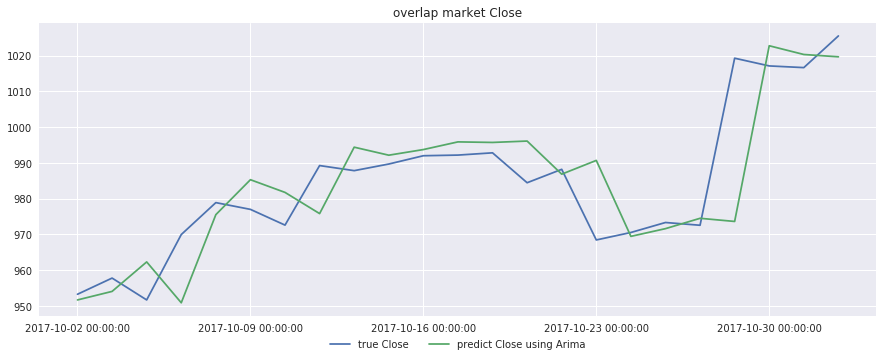

In [ ]:
pred_arima = best_arima.predict()
x_range = np.arange(df_log.shape[0])
fig = plt.figure(figsize = (15,6))
ax = plt.subplot(111)
ax.plot(x_range, reverse_close(df_log.iloc[:,3].values), label = 'true Close')
ax.plot(x_range, reverse_close(pred_arima), label = 'predict Close using Arima')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.xticks(x_range[::5], date_ori[::5])
plt.title('overlap market Close')
plt.show()

In [ ]:
boundary = (thought_vector.shape[0] // timestamp) * timestamp
stack_predict = np.vstack([pred_arima[:boundary], output_predict.reshape((-1))]).T

In [ ]:
where_below_0 = np.where(stack_predict < 0)
where_higher_1 = np.where(stack_predict > 1)
stack_predict[where_below_0[0], where_below_0[1]] = 0
stack_predict[where_higher_1[0], where_higher_1[1]] = 1

In [ ]:
corr_df = pd.DataFrame(np.hstack([stack_predict, df_log.values[:boundary, 3].reshape((-1,1))]))

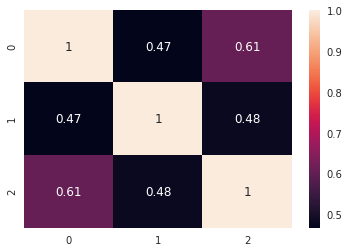

In [ ]:
sns.heatmap(corr_df.corr(), annot= True)
plt.show()

ARIMA able to predict data that correlate 0.61 originally from original Close

Deep Recurrent Neural Network able to predict data that correlate 0.48 originally from original Close

In [ ]:
params_xgd = {
    'max_depth': 7,
    'objective': 'reg:logistic',
    'learning_rate': 0.05,
    'n_estimators': 10000
    }
train_Y = df_log.values[:boundary, 3]
clf = xgb.XGBRegressor(**params_xgd)
clf.fit(stack_predict,train_Y, eval_set=[(stack_predict,train_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=False)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [ ]:
stacked = clf.predict(stack_predict)

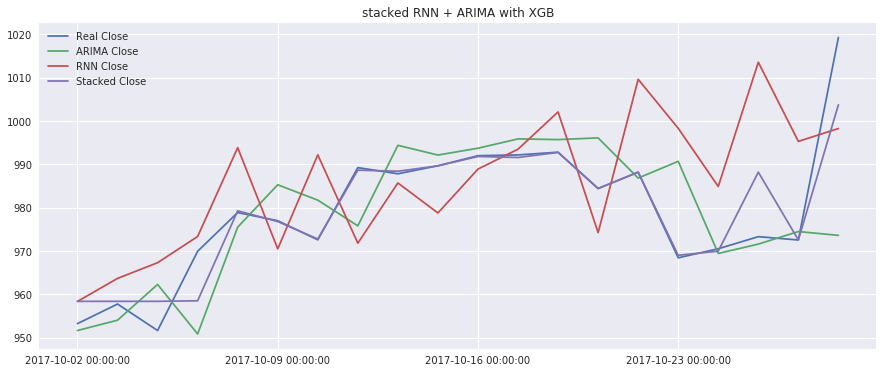

In [ ]:
plt.figure(figsize = (15,6))
x_range = np.arange(boundary)
plt.plot(x_range, reverse_close(train_Y), label = 'Real Close')
plt.plot(x_range, reverse_close(pred_arima[:boundary]), label = 'ARIMA Close')
plt.plot(x_range, reverse_close(output_predict), label = 'RNN Close')
plt.plot(x_range, reverse_close(stacked), label = 'Stacked Close')
plt.legend()
plt.xticks(x_range[::5], date_ori[:boundary][::5])
plt.title('stacked RNN + ARIMA with XGB')
plt.show()

# Pretty insane i can say!

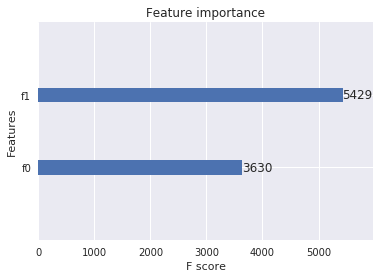

In [ ]:
from xgboost import plot_importance
plot_importance(clf)
plt.show()

## Arima is more important than RNN